In [1]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import numpy as np 
import pandas as pd
import os
from time import perf_counter
import cv2
import tensorflow as tf

### Preproccesing

It is necessary to parse the coordinates of the bounding box from xml files and match them with photos


In [2]:
dataFrame = {
    'image' : [],
    'box'   : [],
}

In [3]:
def Reader(path, annotPath, size = 256, isPlot = False, showTime = False):
    
    start = perf_counter()
    img = plt.imread(path)
    img =  np.array (img[:, :, 0:3])
    
    if isPlot:
        plt.subplot(1, 2, 1)
        plt.imshow(img)
   
    # parsing xml
    with open(annotPath, 'r') as f: 
        data = f.read() 
    
    Bs = BeautifulSoup(data, "xml")
    xMax = int (Bs.find('xmax').text)
    xMin = int (Bs.find('xmin').text)
    yMax = int (Bs.find('ymax').text)
    yMin = int (Bs.find('ymin').text)

    dataFrame['image'].append(cv2.resize(img, (size, size)))

    x = yMin
    while x < yMax:
        y = xMin
        while y < xMax:
            img[x, y, 1] = 1
            y += 1
        x += 1
        
    dataFrame['box'].append (cv2.resize(img, (size, size)))
    
    if isPlot:
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.resize(imgBoxed, (size,size)))
    
    if showTime:
        return perf_counter() - start

In [4]:
def Iterator(imageDir, annotDir):
    start = perf_counter()
    imageNames = os.listdir(imageDir)
    
    for mem in imageNames:
        path = imageDir + '/' + mem
        annotPath = annotDir + '/' + mem.split('.')[0] + '.xml'
        Reader(path, annotPath)
       
    return perf_counter() - start

Parsing 440 photos took almost 5 minutes

In [5]:
Iterator('/content/drive/MyDrive/datasets/car_plates_detection/images', '/content/drive/MyDrive/datasets/car_plates_detection/annotations')

294.943773646

Render a couple of them

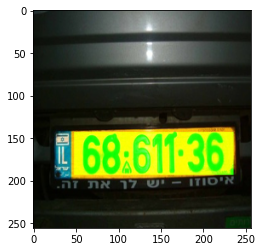

In [23]:
plt.imshow(dataFrame['box'][42])

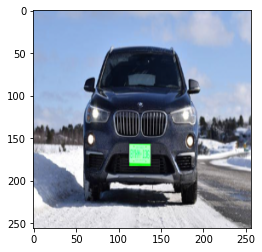

In [25]:
plt.imshow(dataFrame['box'][322])

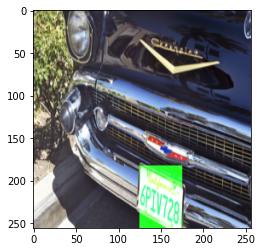

In [26]:
plt.imshow(dataFrame['box'][228])

### Building a Network

To find the number in the picture, we will use the [unet](https://en.wikipedia.org/wiki/U-Net) architecture, it consists of a convolutional and unfolding part, which we have to implement

In [7]:
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [8]:
# init
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

### Learning and Results

In [9]:
retVal = myTransformer.fit(np.array(dataFrame['image']), np.array(dataFrame['box']), epochs = 200, verbose = 1)

Epoch 1/200
14/14 [==============================] - 44s 561ms/step - loss: 0.6460 - accuracy: 0.4107
Epoch 2/200
14/14 [==============================] - 5s 361ms/step - loss: 0.5724 - accuracy: 0.4437
Epoch 3/200
14/14 [==============================] - 5s 362ms/step - loss: 0.5488 - accuracy: 0.4371
Epoch 4/200
14/14 [==============================] - 5s 365ms/step - loss: 0.5348 - accuracy: 0.4712
Epoch 5/200
14/14 [==============================] - 5s 364ms/step - loss: 0.5248 - accuracy: 0.4833
Epoch 6/200
14/14 [==============================] - 5s 368ms/step - loss: 0.5178 - accuracy: 0.5013
Epoch 7/200
14/14 [==============================] - 5s 370ms/step - loss: 0.5126 - accuracy: 0.5243
Epoch 8/200
14/14 [==============================] - 5s 374ms/step - loss: 0.5089 - accuracy: 0.5522
Epoch 9/200
14/14 [==============================] - 5s 375ms/step - loss: 0.5063 - accuracy: 0.5708
Epoch 10/200
14/14 [==============================] - 5s 377ms/step - loss: 0.5033 - accur

Lets see results

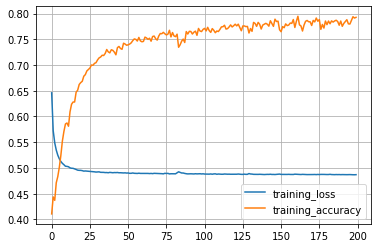

In [10]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

The error becomes stable and almost does not fall after the 25th epoch, while the accuracy gradually increases. This indicates the small size of the dataset.

### Visualizing Results and Saving the Model

In [86]:
def predict_n (n, valMap, model, shape = 256):
    img = valMap['image']
    mask = valMap['box']
    mask = mask[0:n]
    
    imgProc = img[0:n]
    imgProc = np.array(img)

    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(20,10))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('original Image')
    
    filter = np.array([[-1, -1, -1], [-1, 8.99, -1], [-1, -1, -1]]) 
    imgSharpen = cv2.filter2D(predMask,-1,filter)
    
    plt.subplot(1,3,2)
    plt.imshow(imgSharpen)
    plt.title('Predicted Box position')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual box Position')

In [87]:
ten_prediction, actuals, masks = predict_n(10, dataFrame, myTransformer)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

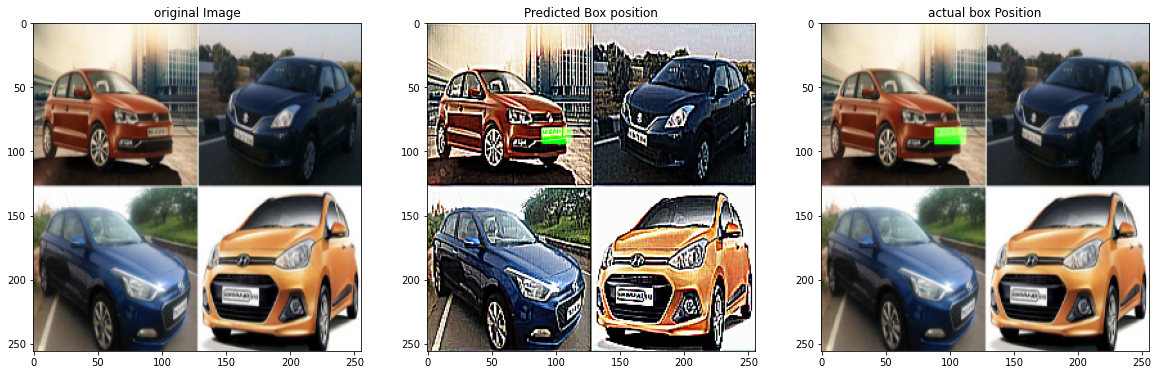

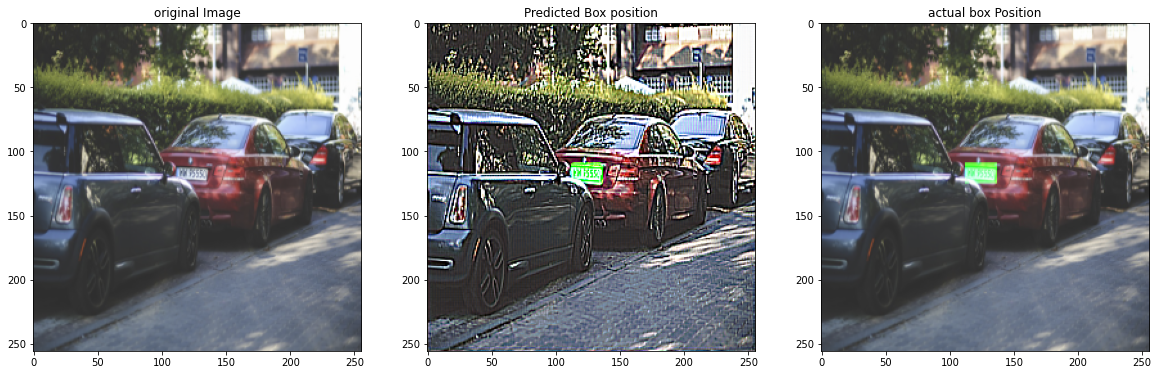

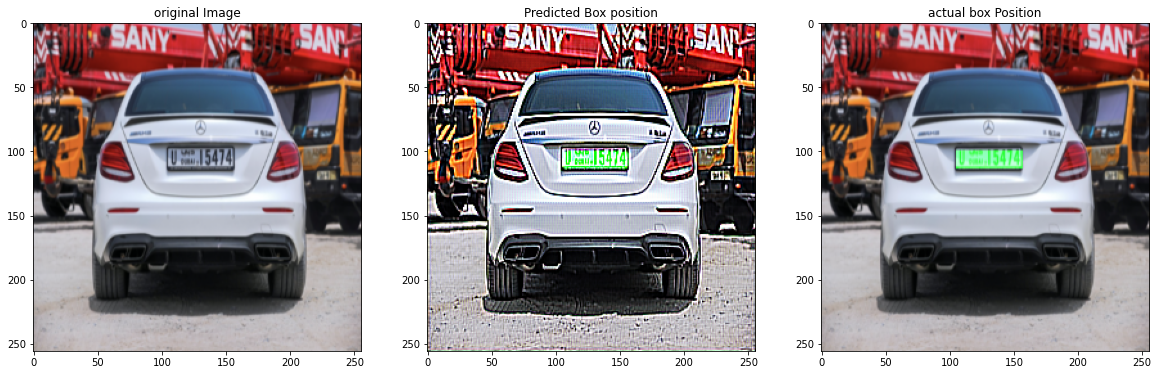

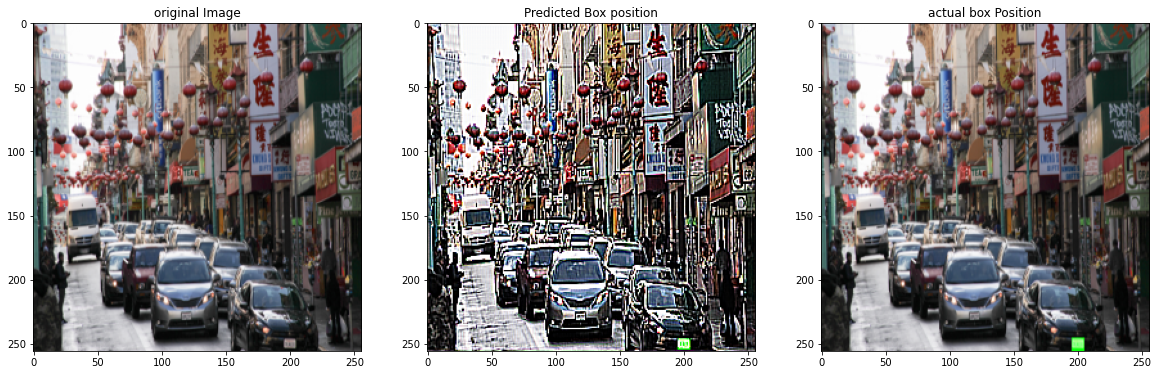

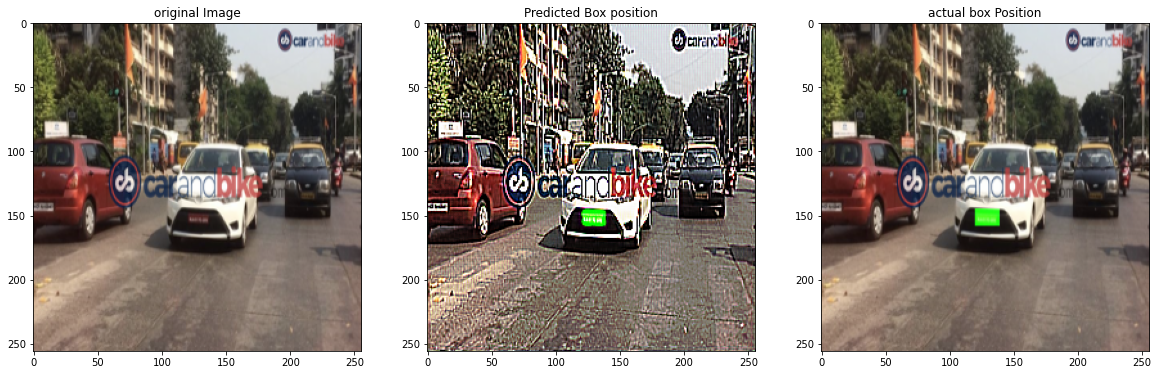

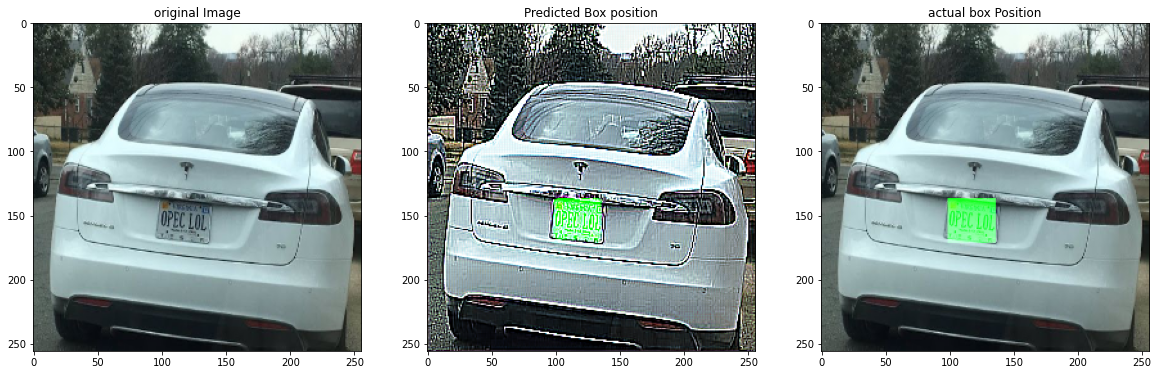

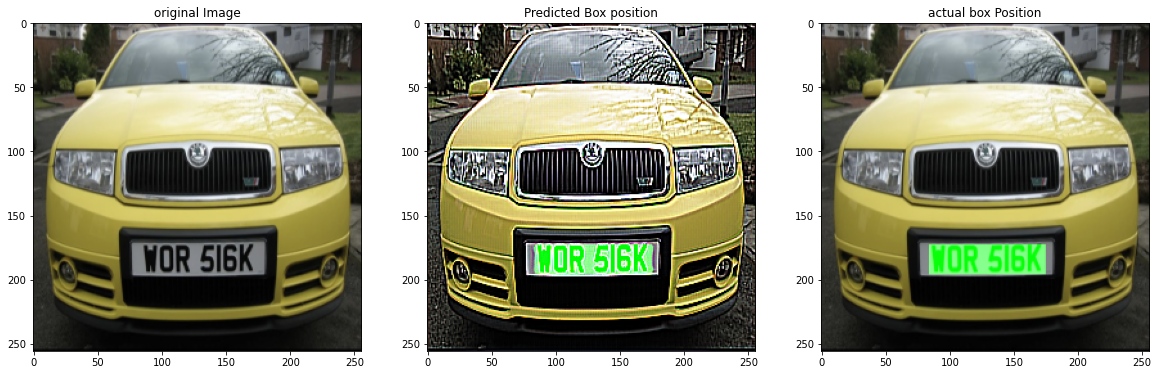

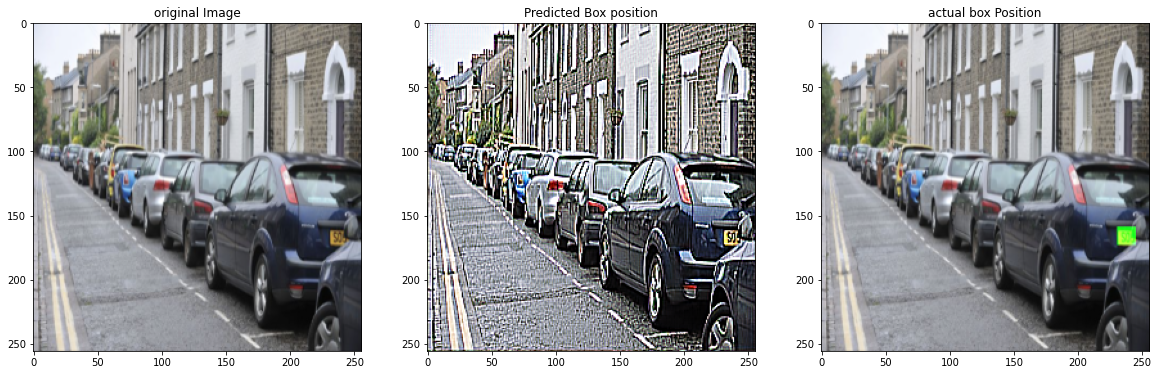

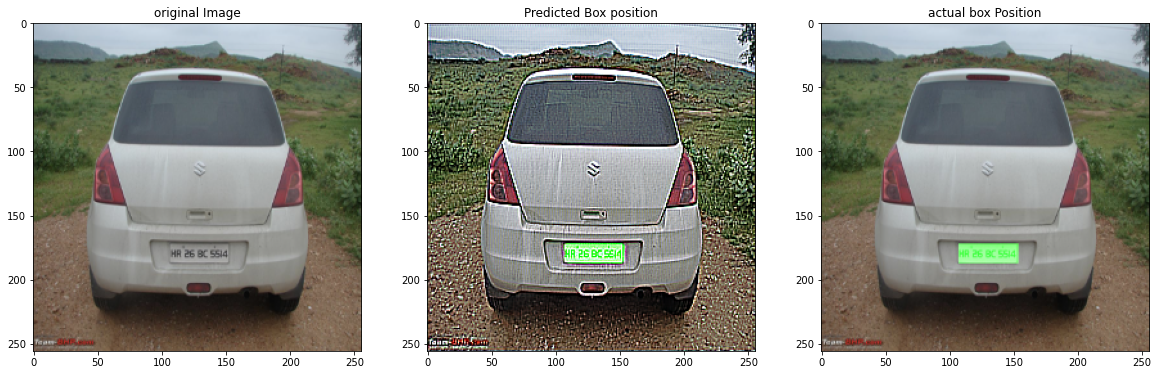

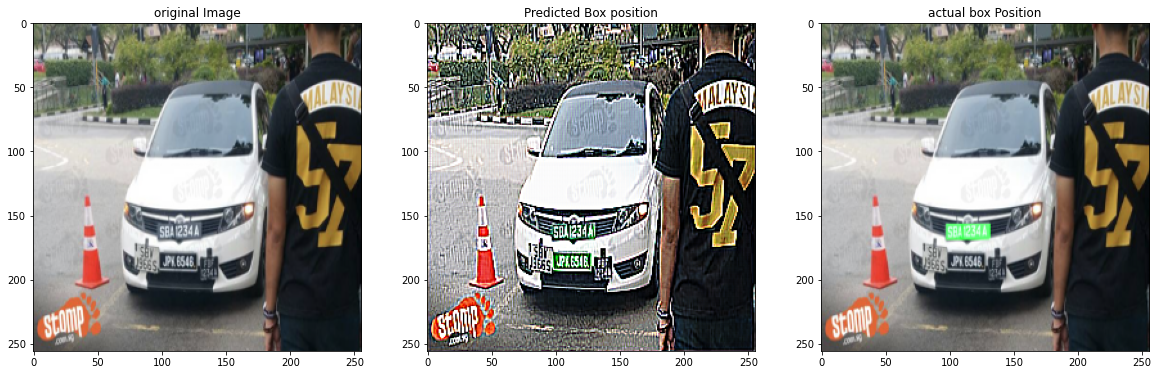

In [88]:
for i in range(10):
  Plotter(actuals[i], ten_prediction[i], masks[i])

And finally save our model

In [15]:
myTransformer.save('/content/drive/MyDrive/datasets/car_plates_detection/ML_PROJECT.h5')